<a href="https://colab.research.google.com/github/osbornep8/nearest-neighbour-from-scratch/blob/main/NearestNeighbour_ImageClassfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To train a Nearest Neighbour Classifier we just memorize the training data, which is quite simple! Your're just storing each training image in memory.

In the code below, you can see X, which contains the __training__ images, is simply stored as an object and y, which contains the labels for each training image, is stored as an object as well

To make predictions on new (__test__) images, which simply loop over each image and compute the L1 (Manhattan) distance for each pixel between the training image[s] and the test image ('test image' singluar! because we are comparing each test image to all the training images we have stored, you will know why in just a sec...):

$$ \\L1 => d(I_1,I_2) = \Sigma_{p}|I_{1}^{p} - I_{2}^{p}| $$

And then, take the sum of these distances which is computed for each pixel value to get one whole '__distance__' value.

After that it's quite simple really, you just index the training image that has the least distance with the test image and find its label. This is how we assume the most similar image to the test image being presented.

And voila! You have classified an image use the nearest neighbour classifier!

In [2]:
class NearestNeighbour():
  def __init__(self) -> None:
    pass
  def train(self, X, y):
    ''' X is a N x D matrix where each row is an example. Y is 1-D matrix of size N'''
    # the nearest neighbour classifier simply remembers all the training examples
    self.Xtr = X
    self.ytr = y

  def predict(self, X, label_map:dict):
    '''X is N x D matrix where each row is an example we wish to predict'''
    num_test= X.shape[0]
    # To make sure that the output type matches in the input type, we just:
    y_pred = np.zeros(shape=num_test)
    output = []

    # Now let's loop over each test example we want to predict i.e., each row of X
    for i in range(num_test):
      # We want to find the nearest training image to the i'th test image
      # Using the L1 distance (sum of absolute differences)
      distances = np.sum(np.abs(self.Xtr - X[i,:]), axis=1) # axis=1 implies a row-wise operation, in this case its the sum operation
      min_index = np.argmin(distances) # get the 'index' with the smallest distance
      y_pred[i] = self.ytr[min_index] # predict the label of the training example
      output.append(label_map[y_pred[i]])
    return output

Now I downloaded some free images of dogs and cats (11 of each to be precise) from https://unsplash.com/ , and I've stored the images in seperate folders labelled 'cat' and 'dog' and an additional folder labelled 'test_img' containing one picture of a cat and dog each. If you haven't gussed already, the folders 'cat' and 'dog' will be used for training the model, while the 'test_img' images will be used to test our model!

However, the filenames look quite unorganzied and as a data scientist you like to keep things neat and organzied. So, let's go ahead and create a function to rename these files to give ourselves more clarity going forward.

In [3]:
base_dir = '/content/drive/MyDrive/CatDog_Dataset/'
cat_dir = os.path.join(base_dir, 'cat')
dog_dir = os.path.join(base_dir, 'dog')

# Here's how the file names in the directory currently look like
os.listdir(cat_dir)

['cat_00.jpg',
 'cat_01.jpg',
 'cat_02.jpg',
 'cat_03.jpg',
 'cat_04.jpg',
 'cat_05.jpg',
 'cat_06.jpg',
 'cat_07.jpg',
 'cat_08.jpg',
 'cat_09.jpg']

In [4]:
def rename_files(dir_path, prefix:str):
  for count, fname in enumerate(os.listdir(dir_path)):
    dst = prefix + '_' + str(count).zfill(2) + '.jpg'
    src = os.path.join(dir_path, fname)
    dst = os.path.join(dir_path, dst)

    #Rename the file in the folder
    os.rename(src, dst)


rename_files(cat_dir, 'cat')
rename_files(dog_dir, 'dog')

# And here's how they look like after renaming
os.listdir(cat_dir)


['cat_00.jpg',
 'cat_01.jpg',
 'cat_02.jpg',
 'cat_03.jpg',
 'cat_04.jpg',
 'cat_05.jpg',
 'cat_06.jpg',
 'cat_07.jpg',
 'cat_08.jpg',
 'cat_09.jpg']

Since we've used NumPy to create the classifier let's just stick with basic libraries to load and open the images as well

In [5]:
from PIL import Image
def load_images(dir_path, size=[128, 128]):
  imgs = []
  for i, img in enumerate(os.listdir(dir_path)):
    img_path = os.path.join(dir_path, img)
    img_file = Image.open(img_path)
    img_resize = img_file.resize(size)
    imgs.append(np.array(img_resize))
  return imgs
cat_imgs = load_images(cat_dir, size=[256,256])
dog_imgs = load_images(dog_dir, size=[256, 256])

This is how the image now looks after resizing. Although the image quality might look more granular, it is a best practice to reduce the image size and more importantly to maitain each image to be the same size.

This is important for two reasons:
1. Computational Efficiency: Larger images take up more memory and require more computational resources to process. By resizing images to a smaller size, you can speed up training and use less memory, which can be especially important when dealing with large datasets or when using hardware with limited resources.

2. Feature Extraction: Resizing images can help to highlight the features that are most important for making predictions. For example, if you’re working with high-resolution images, the model might get “distracted” by irrelevant details and noise. Resizing the images to a lower resolution can help the model to focus on the most important features.

> As you move to using neural networks, where you would use libraries like PyTorch or Tensorflow, it is mandate for the input data to be of the same shape.

Shape of image below:  (256, 256, 3)
Shape of our entire dataset:  (20, 256, 256, 3)


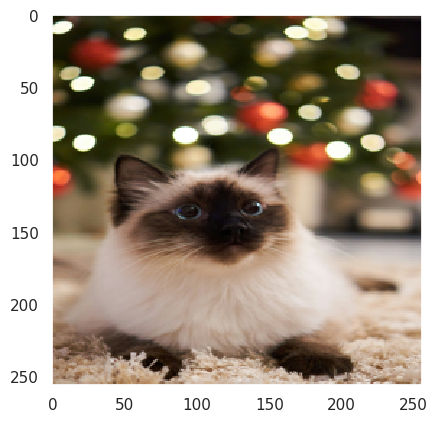

In [6]:
# Let's concatenate the animal datasets to one whole dataset
dset = np.concatenate([cat_imgs, dog_imgs], axis=0)

# A quick view to check that our images have been resize equally
plt.imshow(dset[1],  interpolation='none')
plt.grid(False);
print('Shape of image below: ', dset[1].shape)

# Let's check that shape of our entire dataset to check for uniformity
print('Shape of our entire dataset: ', dset.shape)

There is one issue with this new dataset though, if you remember the 'X' that the __train__ function takes in in our Nearest Neighbour class only accepts a N x D matrix where each row is an example.

So let's go ahead and resize our matrix to match the expected input.

In [7]:
# Since we have a 4D array with shape (20, 256, 256, 3)
# we can simply multiply the height, width and rgb channels together
N, H, W, C = dset.shape
train_dset = dset.reshape(N, H*W*C)

train_dset[0], train_dset[0].shape, train_dset.shape

(array([ 3, 76, 20, ..., 78, 90, 96], dtype=uint8), (196608,), (20, 196608))

Alright, so now that we have converted our images to a more computationally readable format i.e., NumPy arrays and they are all uniform, we just have our class labels left, and then off we go!

In [8]:
# Create a mapping of our class labels (number) to our animals
labels_dict = {0: 'cat', 1: 'dog'}

def create_labels(dir_path, label):
  labels = []
  for fname in os.listdir(dir_path):
    labels.append(label)
  return labels

# Based on our dictonary let's create the labels for the datasets
cat_labels = create_labels(cat_dir, 0)
dog_labels = create_labels(dog_dir, 1)

class_labels = np.concatenate([cat_labels, dog_labels], axis=0)
class_labels.shape, class_labels.dtype

((20,), dtype('int64'))

And there we have it!

A label assigned to each of the image. 0 -> cat and 1 -> dog

---

Now we just have to create an instance of our Nearest Neighbour class and train the model

In [9]:
nn = NearestNeighbour()

# Let's now train the model using our dataset and the class labels
nn.train(X=train_dset, y=class_labels)

Great! So if you have run this code you'll notice that the training time is almost instant.

This is because we are simply storing the arrays in memory! So the train time is constant i.e., time complexity is 0(1). That's pretty convenient isn't it?

---
So now we have a fully trained model! What's next?

Well we simply take an image from our test set and check if our model works!

P.S. we do however have to convert the image into the same format as we did for our input data while training the model

In [10]:
test_images = load_images(dir_path='/content/drive/MyDrive/CatDog_Dataset/test_img', size=[256,256])

test1 = test_images[0]
# test2 = test_images[1]
H,W,C = test1.shape
test1 = test1.reshape((1, H*W*C))
test1.shape, test1

((1, 196608), array([[ 80, 182, 230, ...,  35,  22,  13]], dtype=uint8))

Now, I dont't exactly know which image I have selected. So we will first classify the image using the __predict__ function and then preview the test image to see if we have got it right. Sound good?

Let's go..

In [11]:
nn.predict(X=test1, label_map=labels_dict)

['dog']

The Image Classifier has predicted 'Dog'. The decsision has been made! Now it's time to see if our classifier was indeed correct.

Brace yourself for the moment of truth...

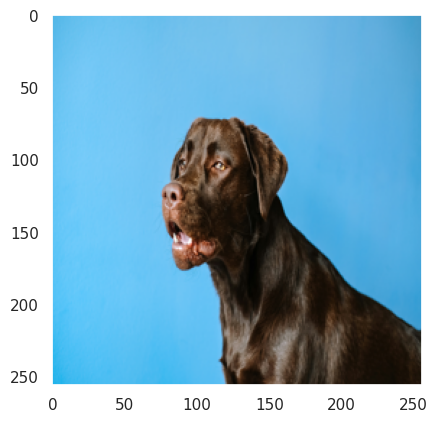

In [12]:
plt.imshow(test_images[0])
plt.grid(False);

Well would you look at that, I mean take a moment to marvel at the majestic __doggo__.

And now give yourself a pat on the back, I know I will! We successfully trained a Nearest Neighbour model using just 10 images for each animal and still managed to to classify the image correctly!

---

Well we've come a long way and I think I need a break before we move onto how we use the 'k value' to enhance the prediction power of our model. But for now I suggest you take a well deserved break because you've completed the biggest part about understanding the Nearest Neighbour model as well as how to utilize a mini-dataset to quickly check our model.

So with that I'll wrap up this article and hope to see you in the next one where we will code an entire K-NN model from scratch!